# 4.3 Simulations and evaluation

### 1. Generate data without any noise, plot the resulting time series and split data into training, validation and test subsets

In [26]:
#Generating data
b = 0.2
g = 0.1
n = 10
tau = 25

def mackey_glass_generato(ini, end, b, g, n, tau):
    res = [1.5]

    for i in range(0, end):
        if i < tau:
            res.append(res[i] - g * res[i] )
        else:
            res.append(res[i] - g * res[i] + b * res[i - tau] / (1 + res[i - tau] ** n))

    return res[ini:end]


init_offset = -20
end_offset = 5

init = 301 
end = 1500 

time_series = mackey_glass_generato(init + init_offset, end + end_offset, b, g, n, tau)

raw_input = []
raw_output = []

for i in range(0, end - init):
    raw_input.append([time_series[i - 20], time_series[i - 15], time_series[i - 10], time_series[i - 5], time_series[i]])
    raw_output.append(time_series[i + 5])

print(time_series)
print(raw_input)
print(raw_output)


[0.894455496300665, 0.9210041638386977, 0.9370200426984308, 0.9441674065454709, 0.9440225667370514, 0.9380006658535759, 0.927308676901778, 0.9129114380687353, 0.8955238082501532, 0.875656522051265, 0.8537292047709524, 0.8302165085694599, 0.8057584284111853, 0.7812121478676817, 0.7576900422998312, 0.7366245563962684, 0.7198603609084644, 0.7097268296159521, 0.7089719084655544, 0.7203682082539361, 0.7458862526798494, 0.7856471138057912, 0.8370073263576152, 0.8941396078323711, 0.9492182519136559, 0.9956701935613437, 1.0308322701149537, 1.0557415651602364, 1.0733151730457458, 1.086800262129608, 1.0989850469988571, 1.1119203379514535, 1.1268792461869386, 1.1444160024521988, 1.1644657304873811, 1.1864567326770443, 1.2094284172099907, 1.232175641678291, 1.2534423175231777, 1.272145163570905, 1.2875732636299209, 1.2995221121837721, 1.3083560195305872, 1.315007435916529, 1.3208931490031741, 1.3276524673967005, 1.3365156940861551, 1.3470733749143893, 1.355594913182702, 1.3548342724292162, 1.33846

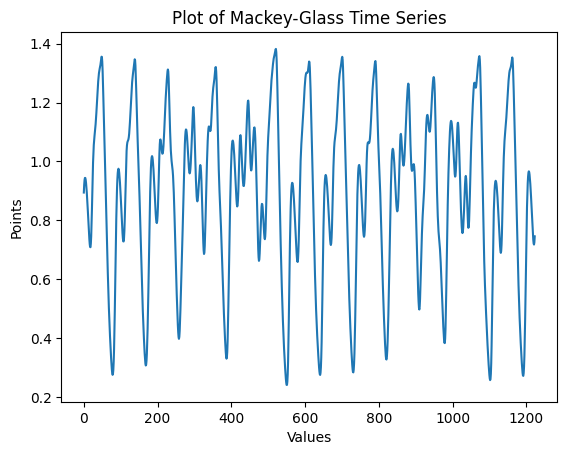

In [27]:
#Plot data
import matplotlib.pyplot as plt

plt.plot(time_series)

plt.xlabel('Values')
plt.ylabel('Points')
plt.title('Plot of Mackey-Glass Time Series')

plt.show()


In [28]:
#Split data
#       note: The exercise says to use 1200 points, from 301 to 1500, but this sum up to 1199 points

train_size = 700
test_size = 300
validation_size = 200

train_X = raw_input[:train_size]
test_X = raw_input[train_size : train_size + test_size]
validation_X = raw_input[train_size + test_size : train_size + test_size + validation_size]

train_y = raw_output[:train_size]
test_y = raw_output[train_size : train_size + test_size]
validation_y = raw_output[train_size + test_size : train_size + test_size + validation_size]


### 4.3.2 Propose a few configurations of a three-layer perceptron with different combinations of the number of nodes in the hidden layer and choose the most and least suitable architectures based on the validation error

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

iter_per_model = 5

            #error, first_layer_size, second_layer_size, learning_rate, model, average_training_time, average_number_of_epochs
best_case = [10000000000, 0, 0, 0, any, 0, 0]
worst_case = [0, 0, 0, 0, any, 0, 0]

single_training_average_time = 0
single_trainings = 0

start_time = time.time()

#  We will iterate over all possible combinations of number of neurons per layer and
# learning rate. Each model will be evaluated 5 times 
# and decided on the average of its MSE.
for first_layer_size in (3, 4, 5):
    for second_layer_size in (2, 4, 6):
        for learning_rate in (0.1, 0.01, 0.001, 0.0001):
            average_mse = 0
            local_training_average_time = 0
            temp_time = 0
            average_epochs = 0
            for i in range(0, iter_per_model):

                model = Sequential()

                model.add(Dense(units=first_layer_size, activation='sigmoid', input_dim=5))
                model.add(Dense(units=second_layer_size, activation='sigmoid'))
                # model.add(Dense(units=2, activation='sigmoid', input_dim=5))
                # model.add(Dense(units=2, activation='sigmoid'))

                model.add(Dense(units=1, activation='linear'))

                model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
                # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

                temp_time = time.time()
                history = model.fit(train_X, train_y, validation_data=(validation_X, validation_y), epochs=1500, verbose=0, callbacks=[early_stopping])
                temp_time = time.time() - temp_time

                mse = model.evaluate(test_X, test_y, verbose=0)

                average_epochs += len(history.history['loss'])
                average_mse += mse
                local_training_average_time += temp_time
                single_trainings += 1

    average_mse /= iter_per_model
    local_training_average_time /= iter_per_model
    average_epochs /= iter_per_model
    if average_mse < best_case[0]:
        best_case = [average_mse, first_layer_size, second_layer_size, learning_rate, model, local_training_average_time, average_epochs]
        # best_case = [average_mse, 0, 0, 0, early_S, model, local_training_average_time, average_epochs]

    if average_mse > worst_case[0]:
        worst_case = [average_mse, first_layer_size, second_layer_size, learning_rate, model, local_training_average_time, average_epochs]
        # worst_case = [average_mse, 0, 0, 0, early_S, model, local_training_average_time, average_epochs]

    single_training_average_time += temp_time


end_time = time.time()

elapsed_time = end_time - start_time
single_training_average_time /= single_trainings

hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
formatted_time = f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"
print(f"Time elapsed (hh:mm:ss): {formatted_time}")
print(f"Number of models trained: {single_trainings}")

hours, remainder = divmod(single_training_average_time, 3600)
minutes, seconds = divmod(remainder, 60)
formatted_time = f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"
print(f"Average time per model (hh:mm:ss): {single_training_average_time}\n")

print("Best case average mse: ", best_case[0], "| first_layer_size: ", best_case[1], "| second_layer_size: ", best_case[2], "| learning_rate: ", best_case[3], "| average_training_time: ", best_case[5], "| average_number_of_epochs: ", best_case[6])
print("Worst case average mse: ", worst_case[0], "| first_layer_size: ", worst_case[1], "| second_layer_size: ", worst_case[2], "| learning_rate: ", worst_case[3], "| average_training_time: ", worst_case[5], "| average_number_of_epochs: ", worst_case[6])                         
        


Time elapsed: 00:02:05
Number of models trained: 4
Average time per model: 20.755470991134644
Best case average mse:  0.0040299646207131445 | first_layer_size:  0 | second_layer_size:  0 | learning_rate:  0 | early_stopping:  False | average_training_time:  40.49931263923645 | average_number_of_epochs:  357.5
Worst case average mse:  0.03776746051153168 | first_layer_size:  0 | second_layer_size:  0 | learning_rate:  0 | early_stopping:  True | average_training_time:  21.924009203910828 | average_number_of_epochs:  206.0


10/10 [==============================] - 0s 1ms/step


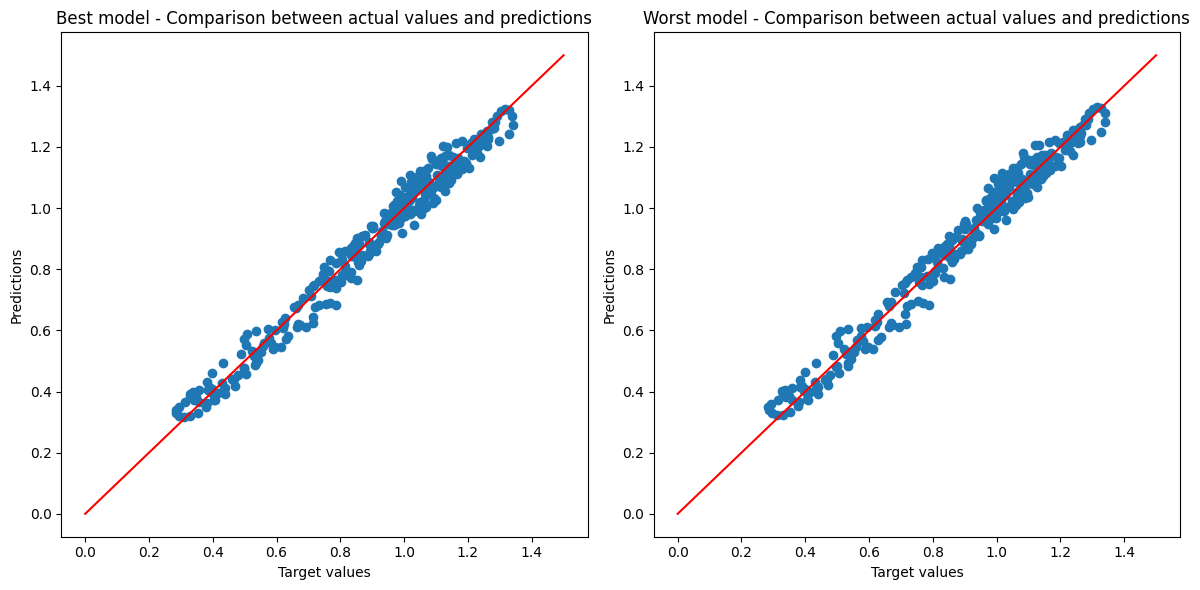

In [43]:
# y_pred = model.predict(test_X)
y_pred_best = best_case[4].predict(test_X)
y_pred_worst = worst_case[4].predict(test_X)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(test_y, y_pred_best)
plt.xlabel("Target values")
plt.ylabel("Predictions")
plt.title("Best model - Comparison between actual values and predictions")

x_line = np.linspace(0, 1.5, 100) 
y_line = x_line 

plt.plot(x_line, y_line, color='red', linestyle='-')         

plt.subplot(1, 2, 2)
plt.scatter(test_y, y_pred_worst)
plt.xlabel("Target values")
plt.ylabel("Predictions")
plt.title("Worst model - Comparison between actual values and predictions")
plt.plot(x_line, y_line, color='red', linestyle='-')         

plt.tight_layout()


plt.show()